# More realizations of the NDE

In [1]:
import numpy as np
import sbi
from sbi.inference import SNPE
import getdist
from getdist import plots, MCSamples
import sys, pathlib, os, random
import torch
import matplotlib.pyplot as plt
import scipy.stats as stats

2024-11-21 17:25:03.391970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 17:25:03.407163: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 17:25:03.411824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 17:25:03.425916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 17:25:04.641107: W tensorflow/compiler/tf2

# Load compressed dv and true paramters

In [2]:
compressed_dv_sims = np.load('../../compression_NN/output/compressed_dv_semi_ae_v1.npy')
compressed_dv_labels = np.load('../../compression_NN/output/pars_LFI.npy')

compressed_dv_fid  = np.load('../../compression_NN/output/dv_compressed_fid_ae_v1.npy')

compressed_dv_fid = compressed_dv_fid.reshape(-1,1).T

In [3]:
# Only infer Omm and S8

compressed_dv_labels = compressed_dv_labels[:,0:2]


In [7]:
def get_posterior_MCSamples(N_rel, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels, nde_config):
    gd_samples = []
    for _ in range(N_rel):
        # define compressed data, parameters, and target (compressed)
        x0 = compressed_dv_fid
        p, l = compressed_dv_sims, compressed_dv_labels


        prior = sbi.utils.BoxUniform(low=torch.tensor(np.min(l, axis=0)), \
            high=torch.tensor(np.max(l, axis=0)))
        inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\
                        model='maf', hidden_features=nde_config['hidden_features'], num_transforms=nde_config['num_transforms']))
        theta, x = torch.tensor(l).float(), torch.tensor(p).float()
        density_estimator = inference.append_simulations(theta, x).train()
        posterior = inference.build_posterior(density_estimator)

        samples = posterior.sample((10000,), x=x0)

        # # all 3
        # gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8', 'A_IA'], \
        #     labels=['Om', 'S8', r'A_{IA}'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
        #         "S8": [np.min(l[:, 1]), np.max(l[:, 1])], "A_IA": [np.min(l[:, 2]), np.max(l[:, 2])]},\
        #         label='test'))
        
        # Om and S8
        gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8'], \
            labels=['Om', 'S8'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
                "S8": [np.min(l[:, 1]), np.max(l[:, 1])]},\
                label='test_'+str(nde_config['test_id']),\
                settings={'smooth_scale_2D':0.45, 'smooth_scale_1D':0.45}))
    return gd_samples

In [5]:
def get_and_plot_FoM(nde_config):
    gd_samples_list = get_posterior_MCSamples(5, compressed_dv_fid, compressed_dv_sims, compressed_dv_labels, nde_config)
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(gd_samples_list, filled=False)

    true = [0.26, 0.78, 0.5]

    # add truth values to get subplot
    for i in range(2):
        for j in range(2):
            if j > i:
                continue
            ax = g.subplots[i, j]
            if i == j:
                ax.axvline(true[i], color="black", ls="--", lw=1)
            else:
                ax.scatter(true[j], true[i], color="black", marker="x", s=20) 
            ax.grid(True, ls="--", lw=1, alpha=0.5)
            
    cov_mat_list = []

    for i in range(len(gd_samples_list)):
        cov_mat_list.append(gd_samples_list[i].getCovMat().matrix)
        
    FoM_list = []
    for i in range(len(gd_samples_list)):
        FoM_list.append(1./np.sqrt(np.linalg.det(cov_mat_list[i])))
        print(f'FoM in test {i} is {FoM_list[i]}')

    FoM_list = np.array(FoM_list)

    print('mean FoM is ', np.mean(FoM_list))

In [9]:
config_list = [{'test_id': '1',
                'hidden_features': 50,
                'num_transforms': 4
               },
               
               {'test_id': '2',
                'hidden_features': 50,
                'num_transforms': 2
               },
               
               {'test_id': '3',
                'hidden_features': 30,
                'num_transforms': 2
               },
              ]


In [11]:
for config in config_list:
    get_and_plot_FoM(config)

/tmp/ipykernel_1365281/2057994799.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 58 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_1365281/2057994799.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 74 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 89 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 56 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 108 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
FoM in test 0 is 2148.042124842228
FoM in test 1 is 2166.5666958009238
FoM in test 2 is 2059.850463897048
FoM in test 3 is 2165.7559103291273
FoM in test 4 is 1967.4656822173329
mean FoM is  2101.5361754173323


/tmp/ipykernel_1365281/2057994799.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 146 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 69 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 82 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 70 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 56 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
FoM in test 0 is 2169.112967961353
FoM in test 1 is 2086.898959010357
FoM in test 2 is 2060.5831955485305
FoM in test 3 is 2158.1403495763725
FoM in test 4 is 626.9941106019202
mean FoM is  1820.3459165397066


/tmp/ipykernel_1365281/2057994799.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 69 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 81 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 46 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 75 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 80 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
FoM in test 0 is 676.3220078798812
FoM in test 1 is 638.3921365610519
FoM in test 2 is 1996.6122436709743
FoM in test 3 is 591.4416232249267
FoM in test 4 is 2207.169913917993
mean FoM is  1221.9875850509657


In [12]:
config_list = [{'test_id': '4',
                'hidden_features': 70,
                'num_transforms': 4
               },
               
               {'test_id': '5',
                'hidden_features': 70,
                'num_transforms': 6
               },
               
               {'test_id': '6',
                'hidden_features': 100,
                'num_transforms': 4
               },
              ]


/tmp/ipykernel_1365281/2057994799.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 51 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 68 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 86 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 50 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 99 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
FoM in test 0 is 2102.0330348414514
FoM in test 1 is 603.7760438587032
FoM in test 2 is 2007.0900124376633
FoM in test 3 is 2140.5815397207725
FoM in test 4 is 2137.202997669707
mean FoM is  1798.1367257056595


/tmp/ipykernel_1365281/2057994799.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 88 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 47 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 80 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 52 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 56 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
FoM in test 0 is 1995.5160050763839
FoM in test 1 is 2104.30906494985
FoM in test 2 is 2009.4298443344474
FoM in test 3 is 2035.311370815054
FoM in test 4 is 2001.5548821675663
mean FoM is  2029.2242334686603


/tmp/ipykernel_1365281/2057994799.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 102 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 66 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 86 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 81 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
 Neural network successfully converged after 97 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in
FoM in test 0 is 2060.606846073208
FoM in test 1 is 571.052536679381
FoM in test 2 is 1891.5623708627572
FoM in test 3 is 1998.4337879425743
FoM in test 4 is 1973.747628888215
mean FoM is  1699.0806340892273


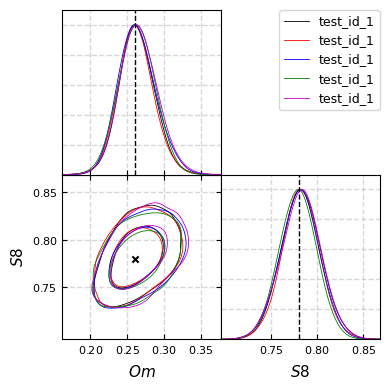

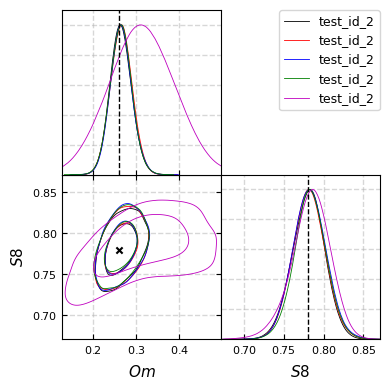

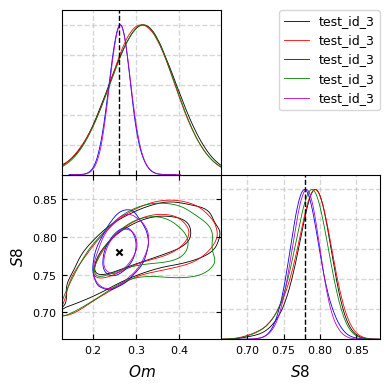

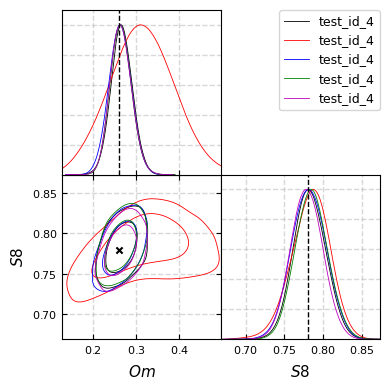

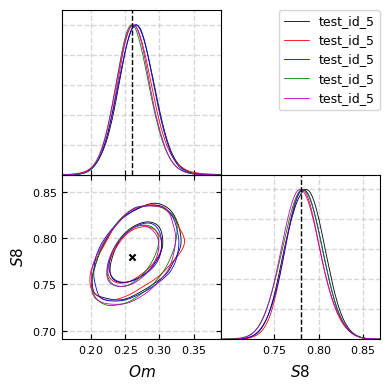

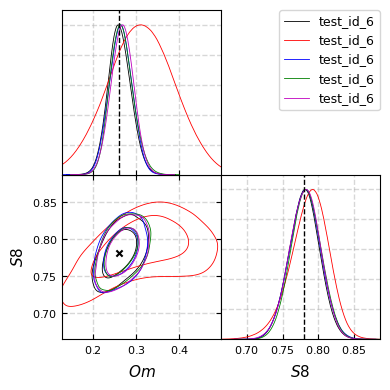

In [13]:
%matplotlib inline 

for config in config_list:
    get_and_plot_FoM(config)